In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Binarizer
from sklearn.tree import DecisionTreeClassifier

[과제] diabetes.csv 데이터세트를 이용해 다음사항을 수행하여 당뇨병 여부를 판단하는 머신러닝 예측 모델을 작성하고 평가하세요.
- SkinThickness 와 Insulin의 0 값은 상당히 많기 때문에 일괄 삭제가 어려우며 평균값으로 대체
- 정확도, 정밀도, 재현율, F1 Score, ROC_AUC Score를 포함하는 평가지표 사용자 함수 작성
- 정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태로 시각화
- 전체적인 성능 평가 지표를 유지하면서 재현율을 약간 향상시키는 임계값 산출
- 산출된 임계값을 적용한 평가

※ 피처 정보  
'Pregnancies'(임신 횟수), 'Glucose'(포도당 부하 검사 수치), 'BloodPressure'(혈압), 
'SkinThickness'(팔 삼두근 뒤쪽의 피하지방 측정값, 'Insulin'(혈청 인슈린),
'BMI'(체질량 지수), 'DiabetesPedigreeFunction'(당뇨 내력 가중치 값), 'Age', 'Outcome'

In [2]:
diabetes_data = pd.read_csv("dataSet/diabetes.csv")
print(diabetes_data["Outcome"].value_counts())
diabetes_data

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


<AxesSubplot:xlabel='BMI', ylabel='Count'>

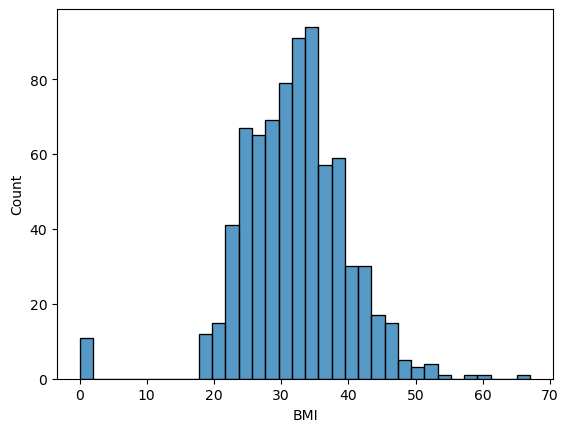

In [4]:
sns.histplot(data = diabetes_data, x = "BMI")

<AxesSubplot:xlabel='Age', ylabel='Count'>

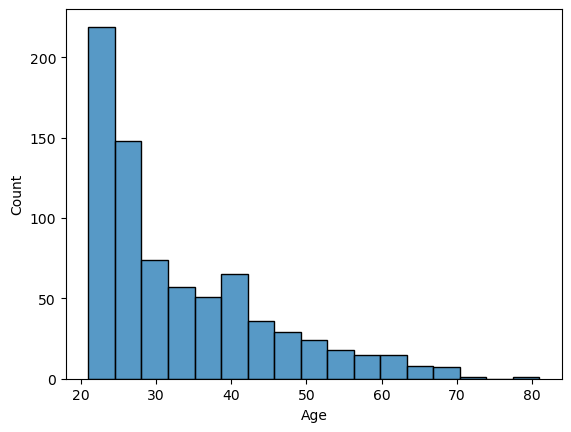

In [5]:
sns.histplot(data = diabetes_data, x = "Age")

In [6]:
diabetes_data["BMI"].describe()

count    768.000000
mean      31.992578
std        7.884160
min        0.000000
25%       27.300000
50%       32.000000
75%       36.600000
max       67.100000
Name: BMI, dtype: float64

In [7]:
def get_clf_eval(y_test = None, pred = None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = round(accuracy_score(y_test, pred),4)
    precision = round(precision_score(y_test, pred),4)
    recall = round(recall_score(y_test, pred),4)
    f1 = round(f1_score(y_test, pred),4)
    roc_auc = round(roc_auc_score(y_test, pred_proba[:, 1]),4)
    print("오차 행렬")
    print(confusion)
    print(f"정확도 : {accuracy}, 정밀도 : {precision}\n재현율 : {recall}, f1 : {f1}")
    print(f"AUC : {roc_auc}")

In [8]:
def BMI_Cat(BMI):
    cat = ''
    if BMI <= -1: cat = 'Unknown'
    elif BMI < 18.5: cat = 'Underweight'
    elif BMI < 23: cat = 'Normalweight'
    elif BMI < 25: cat = "Overweight"
    elif BMI < 30: cat = 'Mild obesity'
    elif BMI < 35: cat = 'Obesity'
    else : cat = 'Severe obesity'
    
    return cat

In [9]:
def Age_Cat(age):
    cat = ''
    if age <= -1: cat = 'Unknown'
    elif age < 30: cat = 'Twenties'
    elif age < 40: cat = 'Young Adult'
    elif age < 50: cat = "Adult"
    elif age < 60: cat = 'Mature'
    else : cat = 'Elderly'
    
    return cat

In [10]:
def precision_recall_curve_plot (y_test = None, pred_proba_c1 = None):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize = (8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle = "--", label = "precision")
    plt.plot(thresholds, recalls[0:threshold_boundary], label = "recall")
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    plt.xlabel("Threshold value")
    plt.ylabel("Precision and Recall value")
    plt.legend()
    plt.grid()

### 과제 4_0517
파마 당뇨병 데이터셋으로 다음을 수행하시오.
- 예측모델 생성 : logistic 적용 및 분류 평가
- precision_recall_curve를 시각화
- 재현율에 비중을 크게 두는 예측 모델을 위한 임곗값을 설정하시오.

In [11]:
diabetes_data["Age_cat"] = diabetes_data['Age'].apply(lambda x : Age_Cat(x))

In [12]:
diabetes_data['BMI'] = diabetes_data.groupby('Age_cat')['BMI'].transform(lambda x: x.replace(0, round(x.mean(),0)))

<AxesSubplot:xlabel='BMI', ylabel='Count'>

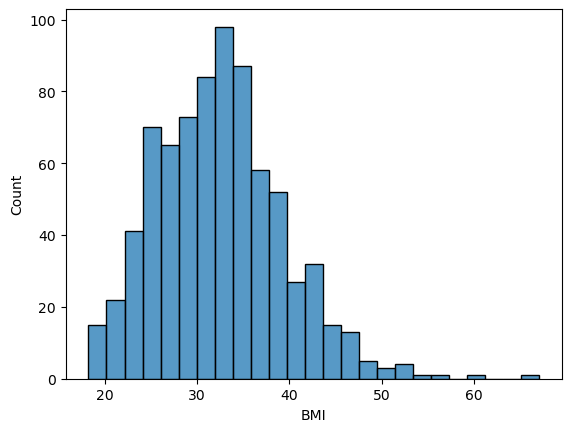

In [13]:
sns.histplot(data = diabetes_data, x = "BMI")

In [14]:
diabetes_data["Insulin"].describe()

count    768.000000
mean      79.799479
std      115.244002
min        0.000000
25%        0.000000
50%       30.500000
75%      127.250000
max      846.000000
Name: Insulin, dtype: float64

In [15]:
diabetes_data["BMI_cat"] = diabetes_data['BMI'].apply(lambda x : BMI_Cat(x))

In [16]:
diabetes_data['SkinThickness'] = diabetes_data.groupby('BMI_cat')['SkinThickness'].transform(lambda x: x.replace(0, round(x.mean(),0)))

In [17]:
diabetes_data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age_cat,BMI_cat
0,6,148,72,35,0,33.6,0.627,50,1,Mature,Obesity
1,1,85,66,29,0,26.6,0.351,31,0,Young Adult,Mild obesity
2,8,183,64,11,0,23.3,0.672,32,1,Young Adult,Overweight
3,1,89,66,23,94,28.1,0.167,21,0,Twenties,Mild obesity
4,0,137,40,35,168,43.1,2.288,33,1,Young Adult,Severe obesity
...,...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0,Elderly,Obesity
764,2,122,70,27,0,36.8,0.340,27,0,Twenties,Severe obesity
765,5,121,72,23,112,26.2,0.245,30,0,Young Adult,Mild obesity
766,1,126,60,20,0,30.1,0.349,47,1,Adult,Obesity


<AxesSubplot:xlabel='Pregnancies', ylabel='Count'>

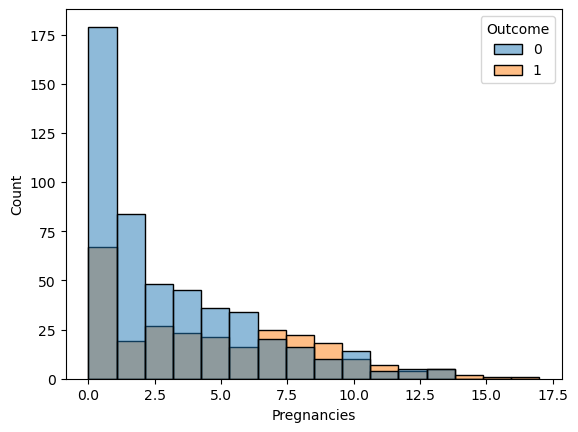

In [18]:
sns.histplot(data = diabetes_data, x = "Pregnancies", hue = "Outcome")

<AxesSubplot:xlabel='Glucose', ylabel='Count'>

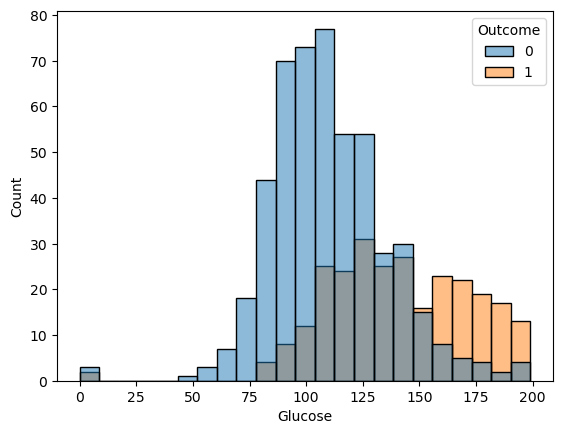

In [19]:
sns.histplot(data = diabetes_data, x = "Glucose", hue = "Outcome")

<AxesSubplot:xlabel='BloodPressure', ylabel='Count'>

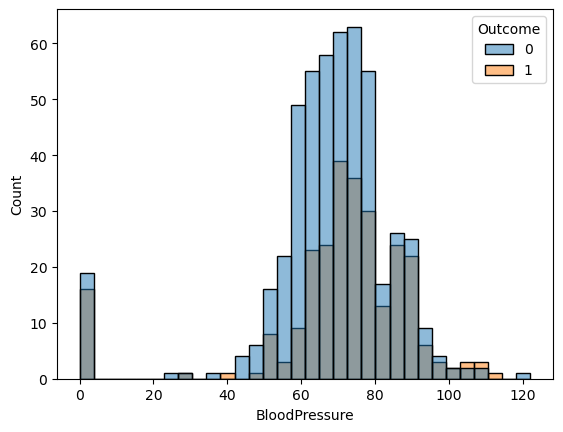

In [20]:
sns.histplot(data = diabetes_data, x = "BloodPressure", hue = "Outcome")

<AxesSubplot:xlabel='SkinThickness', ylabel='Count'>

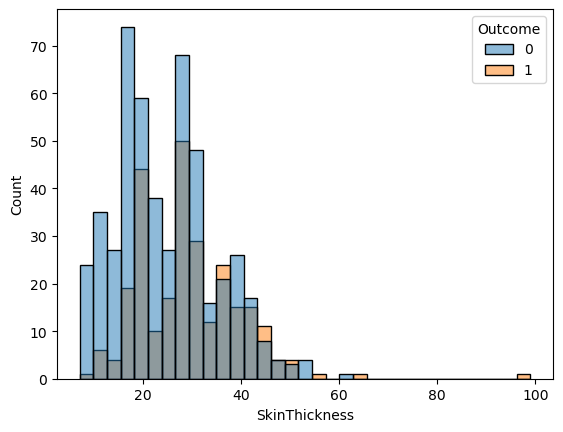

In [21]:
sns.histplot(data = diabetes_data, x = "SkinThickness", hue = "Outcome")

<AxesSubplot:xlabel='Insulin', ylabel='Count'>

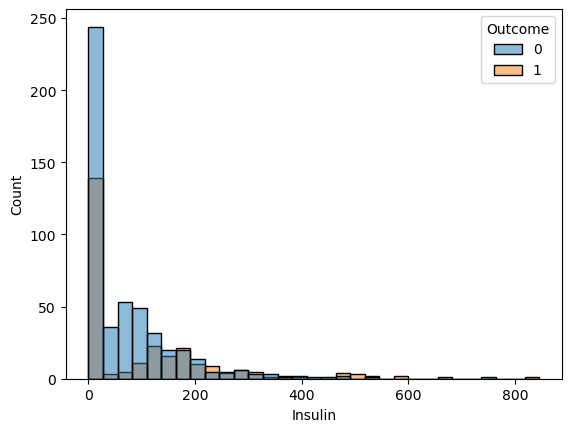

In [22]:
sns.histplot(data = diabetes_data, x = "Insulin", hue = "Outcome")

<AxesSubplot:xlabel='BMI', ylabel='Count'>

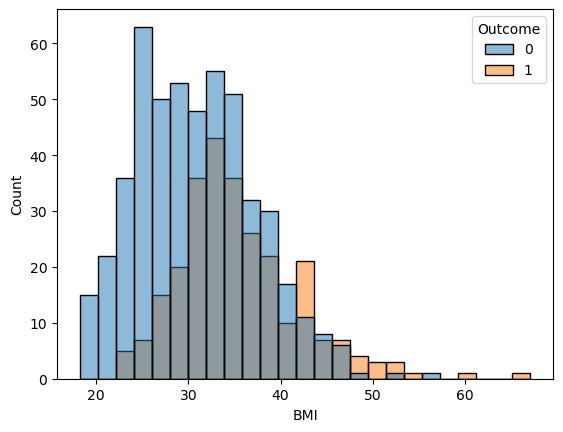

In [23]:
sns.histplot(data = diabetes_data, x = "BMI", hue = "Outcome")

<AxesSubplot:xlabel='DiabetesPedigreeFunction', ylabel='Count'>

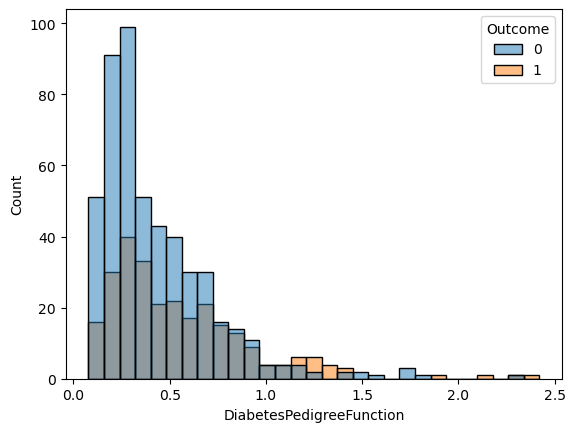

In [24]:
sns.histplot(data = diabetes_data, x = "DiabetesPedigreeFunction", hue = "Outcome")

<AxesSubplot:xlabel='Age', ylabel='Count'>

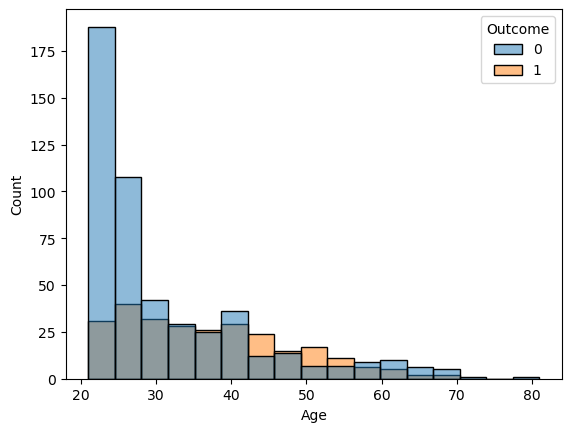

In [25]:
sns.histplot(data = diabetes_data, x = "Age", hue = "Outcome")

<AxesSubplot:xlabel='BMI_cat', ylabel='Count'>

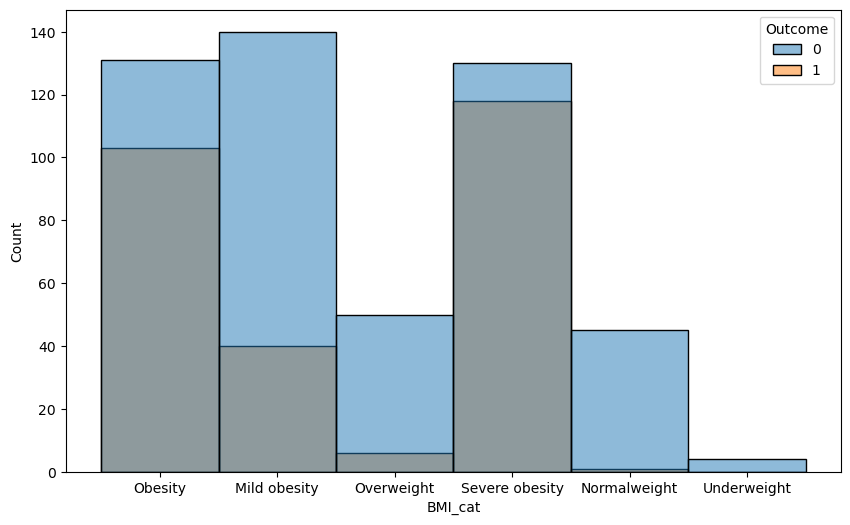

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=diabetes_data, x="BMI_cat", hue="Outcome")

<AxesSubplot:xlabel='Age_cat', ylabel='Count'>

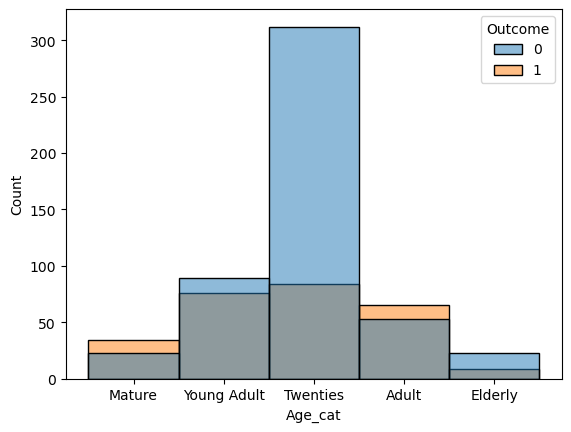

In [27]:
sns.histplot(data=diabetes_data, x="Age_cat", hue="Outcome")

In [28]:
non = diabetes_data.copy()

In [29]:
non = non[non['Insulin'] != 0]

In [30]:
non

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age_cat,BMI_cat
3,1,89,66,23,94,28.1,0.167,21,0,Twenties,Mild obesity
4,0,137,40,35,168,43.1,2.288,33,1,Young Adult,Severe obesity
6,3,78,50,32,88,31.0,0.248,26,1,Twenties,Obesity
8,2,197,70,45,543,30.5,0.158,53,1,Mature,Obesity
13,1,189,60,23,846,30.1,0.398,59,1,Mature,Obesity
...,...,...,...,...,...,...,...,...,...,...,...
753,0,181,88,44,510,43.3,0.222,26,1,Twenties,Severe obesity
755,1,128,88,39,110,36.5,1.057,37,1,Young Adult,Severe obesity
760,2,88,58,26,16,28.4,0.766,22,0,Twenties,Mild obesity
763,10,101,76,48,180,32.9,0.171,63,0,Elderly,Obesity


In [31]:
non.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.201487,0.213740,0.095997,0.082171,-0.023108,-0.000402,0.680920,0.258846
Glucose,0.201487,1.000000,0.203356,0.203526,0.580010,0.212952,0.140409,0.346041,0.512201
BloodPressure,0.213740,0.203356,1.000000,0.232342,0.098272,0.303883,-0.020834,0.299845,0.192819
SkinThickness,0.095997,0.203526,0.232342,1.000000,0.184888,0.664992,0.154056,0.170694,0.257854
Insulin,0.082171,0.580010,0.098272,0.184888,1.000000,0.228355,0.130395,0.220261,0.303454
BMI,-0.023108,0.212952,0.303883,0.664992,0.228355,1.000000,0.154793,0.072196,0.271446
DiabetesPedigreeFunction,-0.000402,0.140409,-0.020834,0.154056,0.130395,0.154793,1.000000,0.076609,0.200759
Age,0.680920,0.346041,0.299845,0.170694,0.220261,0.072196,0.076609,1.000000,0.352982
Outcome,0.258846,0.512201,0.192819,0.257854,0.303454,0.271446,0.200759,0.352982,1.000000


<AxesSubplot:xlabel='Glucose', ylabel='Insulin'>

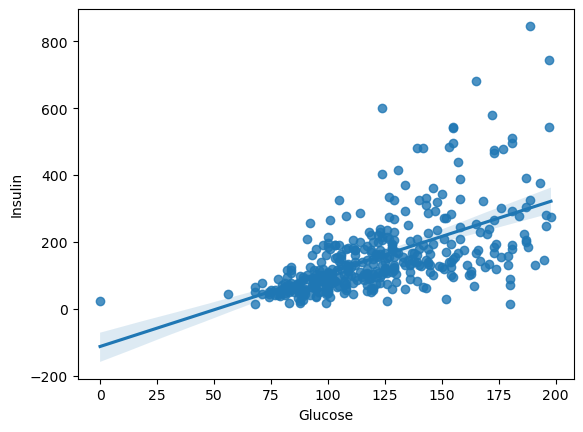

In [32]:
sns.regplot(data = non, x = "Glucose", y = "Insulin")

In [33]:
diabetes_data["Glucose"].describe()

count    768.000000
mean     120.894531
std       31.972618
min        0.000000
25%       99.000000
50%      117.000000
75%      140.250000
max      199.000000
Name: Glucose, dtype: float64

In [34]:
diabetes_data["Glucose"] = diabetes_data['Glucose'].transform(lambda x: x.replace(0, round(x.mean(),0)))

<AxesSubplot:xlabel='Glucose', ylabel='Count'>

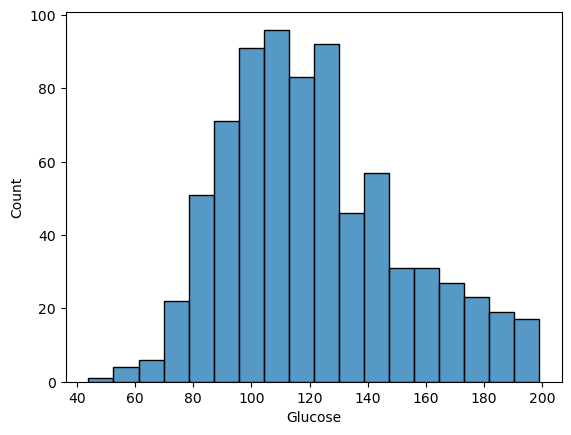

In [35]:
sns.histplot(data = diabetes_data, x = "Glucose")

In [36]:
def Glu_Cat(age):
    cat = ''
    if age <= -1: cat = 'Unknown'
    elif age < 70: cat = 'Low'
    elif age < 109: cat = 'Standard'
    elif age < 126: cat = "High"
    elif age < 160: cat = 'Very high'
    else : cat = 'Extra high'
    
    return cat

In [37]:
diabetes_data["Glu_cat"] = diabetes_data['Glucose'].apply(lambda x : Glu_Cat(x))

<AxesSubplot:xlabel='Glu_cat', ylabel='Count'>

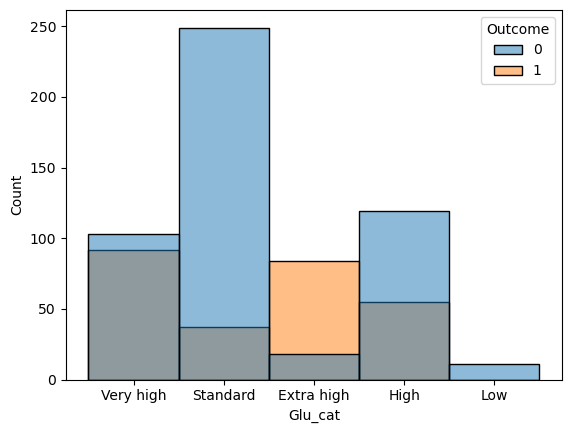

In [38]:
sns.histplot(data=diabetes_data, x="Glu_cat", hue="Outcome")

In [39]:
diabetes_data['Insulin'] = diabetes_data.groupby('Glu_cat')['Insulin'].transform(lambda x: x.replace(0, round(x.mean(),0)))

<AxesSubplot:xlabel='Insulin', ylabel='Count'>

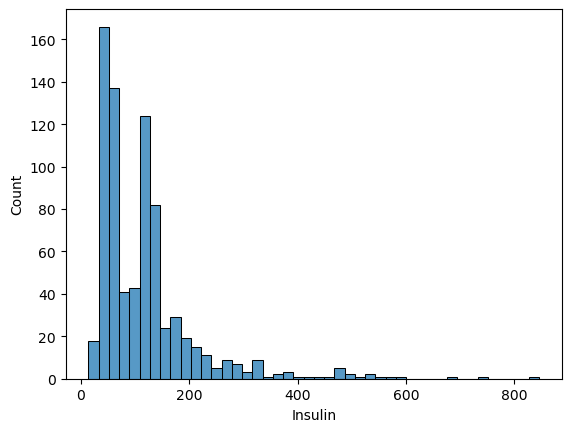

In [40]:
sns.histplot(data = diabetes_data, x = "Insulin")

<AxesSubplot:xlabel='Insulin', ylabel='Count'>

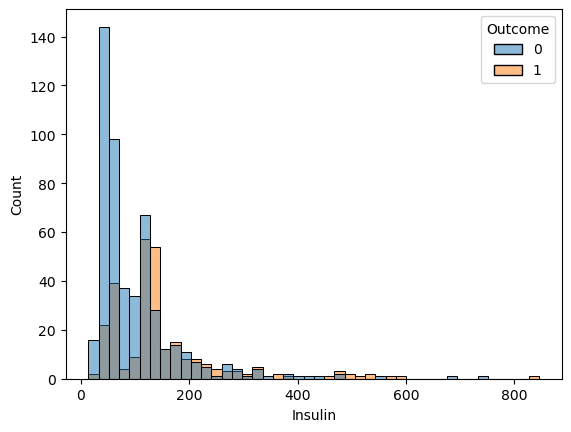

In [41]:
sns.histplot(data = diabetes_data, x = "Insulin", hue = "Outcome")

In [42]:
diabetes_data['BloodPressure'] = diabetes_data.groupby('BMI_cat')['BloodPressure'].transform(lambda x: x.mask(x < 40, round(x.mean(), 0)))

<AxesSubplot:xlabel='BloodPressure', ylabel='Count'>

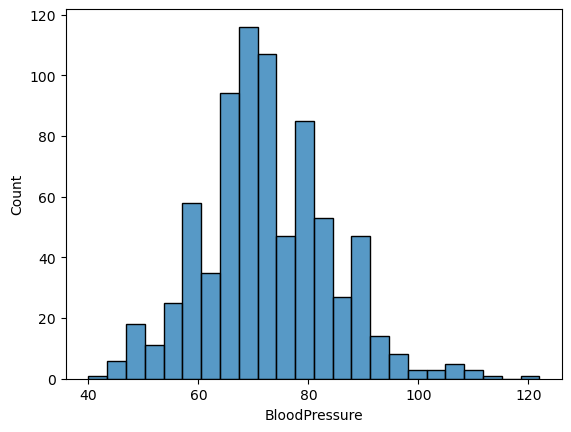

In [43]:
sns.histplot(data = diabetes_data, x = "BloodPressure")

<AxesSubplot:xlabel='BloodPressure', ylabel='Count'>

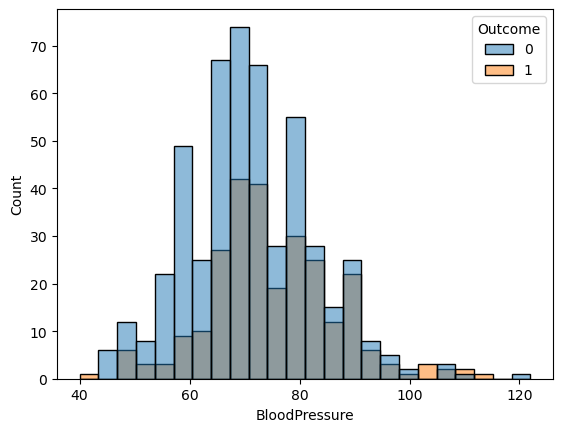

In [44]:
sns.histplot(data = diabetes_data, x = "BloodPressure", hue = "Outcome")

In [45]:
def BP_Cat(BP):
    cat = ''
    if BP <= -1: cat = 'Unknown'
    elif BP < 60: cat = 'Low'
    elif BP < 90: cat = 'Standard'
    else : cat = 'High'
    
    return cat

In [46]:
diabetes_data["BP_cat"] = diabetes_data['BloodPressure'].apply(lambda x : BP_Cat(x))

<AxesSubplot:xlabel='BP_cat', ylabel='Count'>

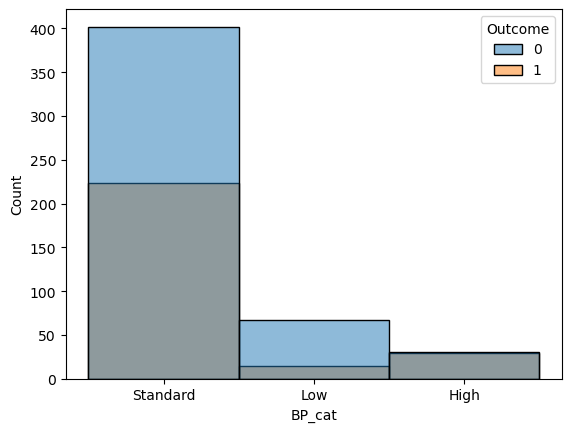

In [47]:
sns.histplot(data = diabetes_data, x = "BP_cat", hue = "Outcome")

<AxesSubplot:xlabel='SkinThickness', ylabel='Count'>

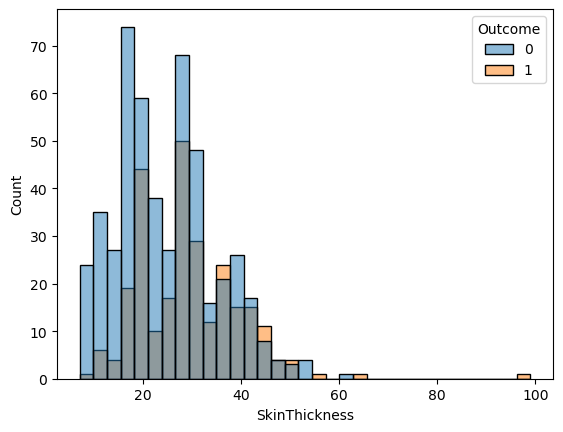

In [48]:
sns.histplot(data = diabetes_data, x = "SkinThickness", hue = "Outcome")

<AxesSubplot:xlabel='Insulin', ylabel='Count'>

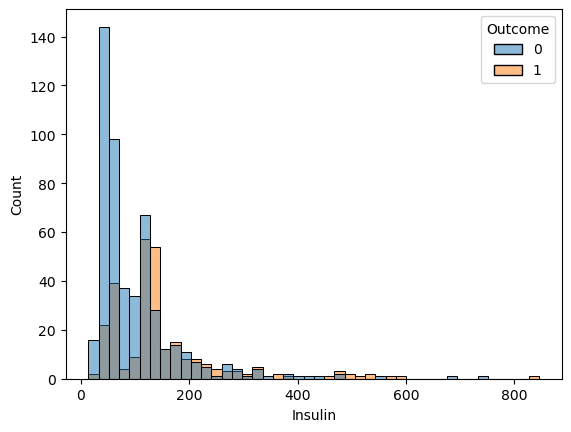

In [49]:
sns.histplot(data = diabetes_data, x = "Insulin", hue = "Outcome")

In [50]:
def Ins_Cat(Ins):
    cat = ''
    if Ins <= -1: cat = 'Unknown'
    elif Ins < 50: cat = 'Low'
    elif Ins < 100: cat = 'Standard'
    elif Ins < 150: cat = 'High'
    elif Ins < 200: cat = 'Very high'
    else : cat = 'Extra high'
    
    return cat

In [51]:
diabetes_data["Ins_cat"] = diabetes_data['Insulin'].apply(lambda x : Ins_Cat(x))

<AxesSubplot:xlabel='Ins_cat', ylabel='Count'>

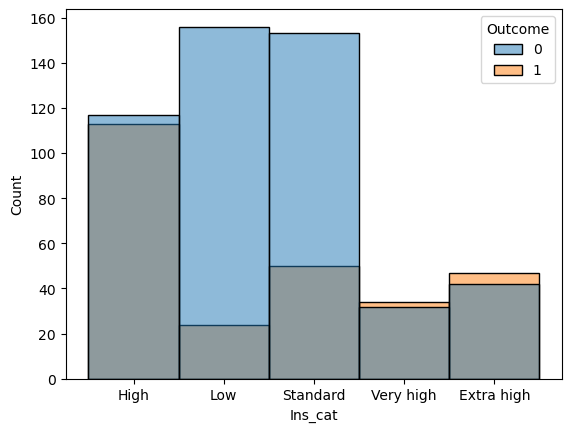

In [52]:
sns.histplot(data = diabetes_data, x = "Ins_cat", hue = "Outcome")

<AxesSubplot:xlabel='DiabetesPedigreeFunction', ylabel='Count'>

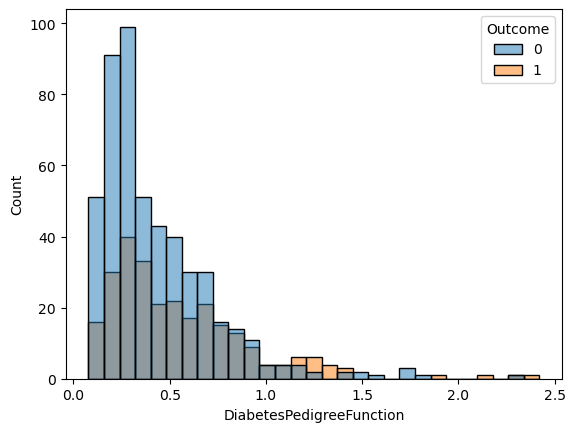

In [53]:
sns.histplot(data = diabetes_data, x = "DiabetesPedigreeFunction", hue = "Outcome")

In [54]:
def DPF_Cat(DPF):
    cat = ''
    if DPF <= -1: cat = 'Unknown'
    elif DPF < 0.5: cat = 'Low'
    elif DPF < 0.7: cat = 'Standard'
    elif DPF < 1: cat = 'High'    
    else : cat = 'Extra high'
    
    return cat

In [55]:
diabetes_data["DPF_cat"] = diabetes_data['DiabetesPedigreeFunction'].apply(lambda x : DPF_Cat(x))

<AxesSubplot:xlabel='DPF_cat', ylabel='Count'>

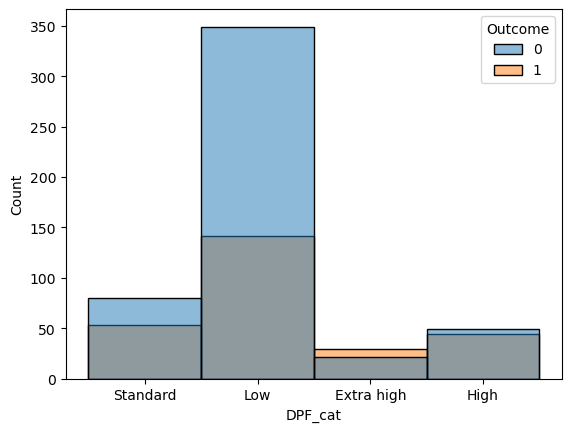

In [56]:
sns.histplot(data = diabetes_data, x = "DPF_cat", hue = "Outcome")

In [57]:
diabetes_data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age_cat,BMI_cat,Glu_cat,BP_cat,Ins_cat,DPF_cat
0,6,148,72.0,35,111,33.6,0.627,50,1,Mature,Obesity,Very high,Standard,High,Standard
1,1,85,66.0,29,48,26.6,0.351,31,0,Young Adult,Mild obesity,Standard,Standard,Low,Low
2,8,183,64.0,11,143,23.3,0.672,32,1,Young Adult,Overweight,Extra high,Standard,High,Standard
3,1,89,66.0,23,94,28.1,0.167,21,0,Twenties,Mild obesity,Standard,Standard,Standard,Low
4,0,137,40.0,35,168,43.1,2.288,33,1,Young Adult,Severe obesity,Very high,Low,Very high,Extra high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10,101,76.0,48,180,32.9,0.171,63,0,Elderly,Obesity,Standard,Standard,Very high,Low
764,2,122,70.0,27,64,36.8,0.340,27,0,Twenties,Severe obesity,High,Standard,Standard,Low
765,5,121,72.0,23,112,26.2,0.245,30,0,Young Adult,Mild obesity,High,Standard,High,Low
766,1,126,60.0,20,111,30.1,0.349,47,1,Adult,Obesity,Very high,Standard,High,Low


In [179]:
def transform_features(df):
    df["Age_cat"] = df['Age'].apply(lambda x : Age_Cat(x))
    
    df['BMI'] = df.groupby('Age')['BMI'].transform(lambda x: x.replace(0, round(x.mean(),0)))
    
    df["BMI_cat"] = df['BMI'].apply(lambda x : BMI_Cat(x))
    
    df['SkinThickness'] = df.groupby('BMI_cat')['SkinThickness'].transform(lambda x: x.replace(0, round(x.mean(),0)))
    
    df["Glucose"] = df['Glucose'].transform(lambda x: x.replace(0, round(x.mean(),0)))
    
    df["Glu_cat"] = df['Glucose'].apply(lambda x : Glu_Cat(x))
    
    df['Insulin'] = df.groupby('Glu_cat')['Insulin'].transform(lambda x: x.replace(0, round(x.mean(),0)))
    
    df["BP_cat"] = df['BloodPressure'].apply(lambda x : BP_Cat(x))
    
    df["Ins_cat"] = df['Insulin'].apply(lambda x : Ins_Cat(x))
    
    df["DPF_cat"] = df['DiabetesPedigreeFunction'].apply(lambda x : DPF_Cat(x))
    
    df.drop(["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age" , "BP_cat"] 
            , axis=1, inplace=True)
    
    features = ["Age_cat", "Glu_cat", "DPF_cat", "BMI_cat", "Ins_cat"]
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

In [144]:
diabetes_data = pd.read_csv("dataSet/diabetes.csv")

y_dia_df = diabetes_data['Outcome']
X_dia_df= diabetes_data.drop('Outcome',axis=1)

X_dia_df = transform_features(X_dia_df)

X_train, X_test, y_train, y_test=train_test_split(X_dia_df, y_dia_df, \
                                                  test_size=0.2, random_state=156)
lr_clf = LogisticRegression(random_state=156)

In [172]:
lr_clf.fit(X_train , y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)
print('LogisticRegression 정확도: {0:.4f}'.format(accuracy_score(y_test, lr_pred)))

LogisticRegression 정확도: 0.6818


In [135]:
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[91  9]
 [37 17]]
정확도 : 0.7013, 정밀도 : 0.6538
재현율 : 0.3148, f1 : 0.425
AUC : 0.7417


In [143]:
thresholds = [0.25, 0.3, 0.35 ,0.4, 0.45, 0.5, 0.55, 0.6]

for i in thresholds:
    lr_pred_proba_1 = lr_pred_proba[:,1].reshape(-1,1)
    binarizer = Binarizer(threshold = i).fit(lr_pred_proba_1)
    custom_predict = binarizer.transform(lr_pred_proba_1)
    print(i)

    get_clf_eval(y_test, custom_predict, lr_pred_proba)

0.25
오차 행렬
[[52 45]
 [15 42]]
정확도 : 0.6104, 정밀도 : 0.4828
재현율 : 0.7368, f1 : 0.5833
AUC : 0.7101
0.3
오차 행렬
[[62 35]
 [19 38]]
정확도 : 0.6494, 정밀도 : 0.5205
재현율 : 0.6667, f1 : 0.5846
AUC : 0.7101
0.35
오차 행렬
[[71 26]
 [25 32]]
정확도 : 0.6688, 정밀도 : 0.5517
재현율 : 0.5614, f1 : 0.5565
AUC : 0.7101
0.4
오차 행렬
[[82 15]
 [30 27]]
정확도 : 0.7078, 정밀도 : 0.6429
재현율 : 0.4737, f1 : 0.5455
AUC : 0.7101
0.45
오차 행렬
[[84 13]
 [31 26]]
정확도 : 0.7143, 정밀도 : 0.6667
재현율 : 0.4561, f1 : 0.5417
AUC : 0.7101
0.5
오차 행렬
[[87 10]
 [33 24]]
정확도 : 0.7208, 정밀도 : 0.7059
재현율 : 0.4211, f1 : 0.5275
AUC : 0.7101
0.55
오차 행렬
[[88  9]
 [34 23]]
정확도 : 0.7208, 정밀도 : 0.7188
재현율 : 0.4035, f1 : 0.5169
AUC : 0.7101
0.6
오차 행렬
[[90  7]
 [39 18]]
정확도 : 0.7013, 정밀도 : 0.72
재현율 : 0.3158, f1 : 0.439
AUC : 0.7101


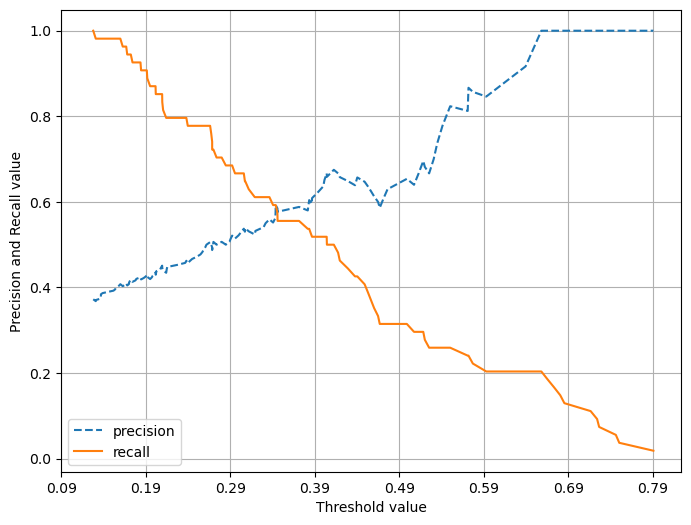

In [64]:
def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
#     print(list(thresholds))
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
#     print(threshold_boundary)
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot( y_test, lr_pred_proba[:, 1] )

In [200]:
diabetes_data = pd.read_csv("dataSet/diabetes.csv")

y_dia_df = diabetes_data['Outcome']
X_dia_df= diabetes_data.drop('Outcome',axis=1)

X_dia_df = transform_features(X_dia_df)

X_train, X_test, y_train, y_test=train_test_split(X_dia_df, y_dia_df, \
                                                  test_size=0.2, random_state=156)
dt_clf = DecisionTreeClassifier(criterion = "gini", max_depth = 3, random_state = 156)

In [199]:
dt_clf.fit(X_train , y_train)
dt_pred = dt_clf.predict(X_test)
dt_pred_proba = dt_clf.predict_proba(X_test)
print('DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))

DecisionTreeClassifier 정확도: 0.7597


In [185]:
thresholds = [0.25, 0.3, 0.35 ,0.4, 0.45, 0.5, 0.55, 0.6]

for i in thresholds:
    dt_pred_proba_1 = dt_pred_proba[:,1].reshape(-1,1)
    binarizer = Binarizer(threshold = i).fit(dt_pred_proba_1)
    custom_predict = binarizer.transform(dt_pred_proba_1)
    print(i)

    get_clf_eval(y_test, custom_predict, dt_pred_proba)

0.25
오차 행렬
[[64 33]
 [13 44]]
정확도 : 0.7013, 정밀도 : 0.5714
재현율 : 0.7719, f1 : 0.6567
AUC : 0.7681
0.3
오차 행렬
[[64 33]
 [13 44]]
정확도 : 0.7013, 정밀도 : 0.5714
재현율 : 0.7719, f1 : 0.6567
AUC : 0.7681
0.35
오차 행렬
[[82 15]
 [22 35]]
정확도 : 0.7597, 정밀도 : 0.7
재현율 : 0.614, f1 : 0.6542
AUC : 0.7681
0.4
오차 행렬
[[82 15]
 [22 35]]
정확도 : 0.7597, 정밀도 : 0.7
재현율 : 0.614, f1 : 0.6542
AUC : 0.7681
0.45
오차 행렬
[[82 15]
 [22 35]]
정확도 : 0.7597, 정밀도 : 0.7
재현율 : 0.614, f1 : 0.6542
AUC : 0.7681
0.5
오차 행렬
[[82 15]
 [22 35]]
정확도 : 0.7597, 정밀도 : 0.7
재현율 : 0.614, f1 : 0.6542
AUC : 0.7681
0.55
오차 행렬
[[82 15]
 [22 35]]
정확도 : 0.7597, 정밀도 : 0.7
재현율 : 0.614, f1 : 0.6542
AUC : 0.7681
0.6
오차 행렬
[[93  4]
 [38 19]]
정확도 : 0.7273, 정밀도 : 0.8261
재현율 : 0.3333, f1 : 0.475
AUC : 0.7681


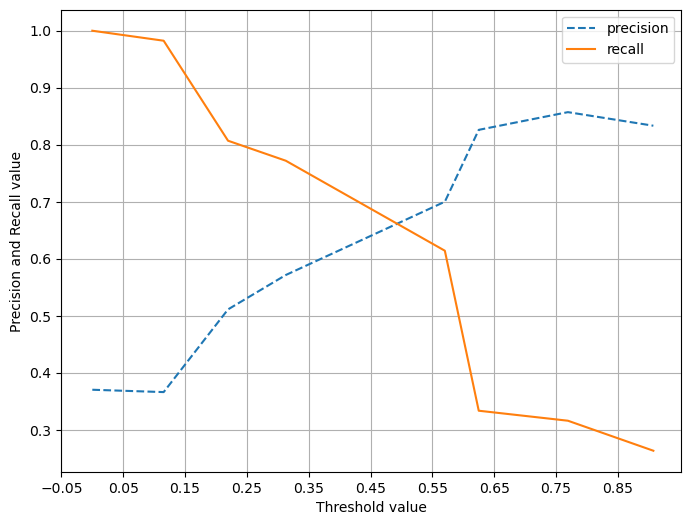

In [153]:
precision_recall_curve_plot( y_test, dt_pred_proba[:, 1] )